# TIME SERIES FORECASTING

## FORECASTING THE HOURLY ENERGY CONSUMPTION USING XGBOOST

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia. The hourly power consumption data comes from PJM's website and are in megawatts (MW). The dataset comprises of the hourly power consumption data ranging from 2002-2018 for entire east US region.

#### TASK: WE WOULD BE PREDICTING THE FUTURE VALUES FOR ENERGY CONSUMPTION BASED ON HOURLY TIME INTERVAL

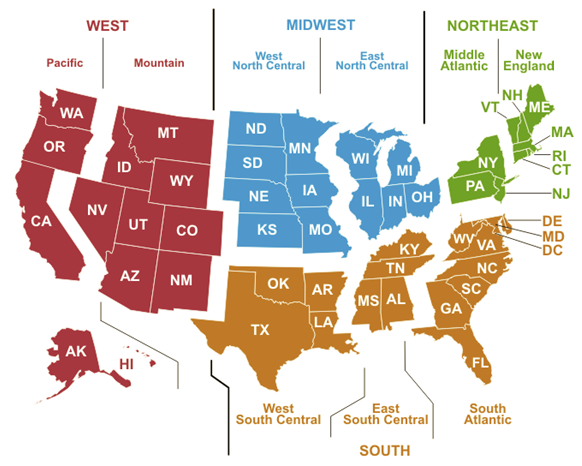

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# we would be using the root mean squared error (RMSE) as the error metric
from sklearn.metrics import classification_report, mean_squared_error

# importing xgboost as we would be using the XGBoost model for forecasting on our dataset
import xgboost as xgb

### TYPES OF TIME SERIES DATA:
- Purely Random Error (no recognisable pattern)
- Curvilinear Trend (quadratic, exponential)
- Increasing/Decreasing Linear Trend
- Seasonal Pattern (ups and downs)
- Seasonal Pattern plus Linear Growth

In [2]:
df = pd.read_csv('../Self-Practice/Datasets/PJME_hourly.csv')

In [3]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [4]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [5]:
# analyzing the head and tail segment of the dataset, the file includes data all the way from 2002 - 2018

In [6]:
# setting up the 'Datetime' column as our index
df = df.set_index('Datetime')
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [7]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


<AxesSubplot:xlabel='Datetime'>

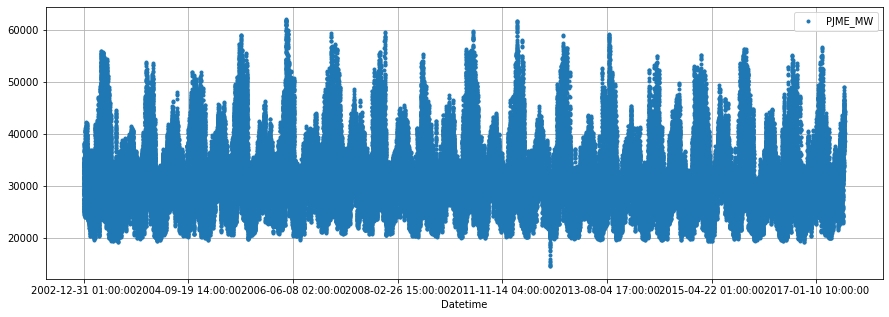

In [8]:
color_pal = sns.color_palette()
df.plot(style='.',
        figsize=(15,5),
        color=color_pal[0],
        grid=True)

In [9]:
df.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

In [10]:
# the 'datetime' values are represented as string as seen in above graph owing to the 'Datetime' column values being object type
# for better visualization, we need to transform the datetime values to the 'Datetime' data type

<AxesSubplot:title={'center':'PJM Hourly Energy Consumption in MW'}, xlabel='Datetime'>

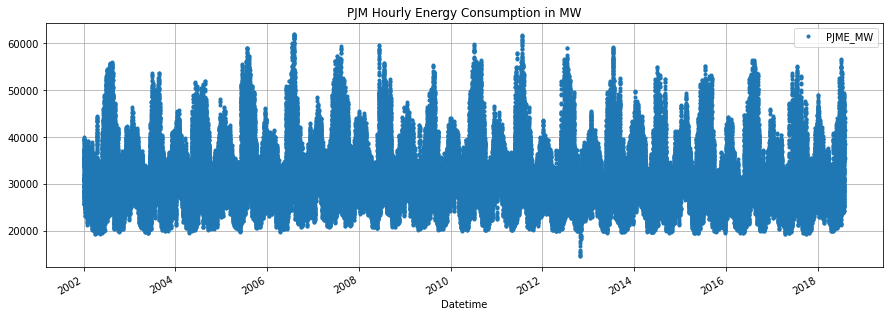

In [11]:
df.index = pd.to_datetime(df.index)
df.plot(style='.',
        figsize=(15,5),
        color=color_pal[0],
        grid=True,
        title='PJM Hourly Energy Consumption in MW')

Visualizing the graph above, we could notice some sort of outliers in b/w the 2012-2014 grid, where the power consumption values are extremely low compared to the overall dataset. Now, this could be a scenario, wherein there would have been an outage or some sort of an issue with the power units/hub, leading to low scores in terms of power consumption. So, herein we would be following the **outlier removal** rule, so that these outliers do not affect our model.

<AxesSubplot:>

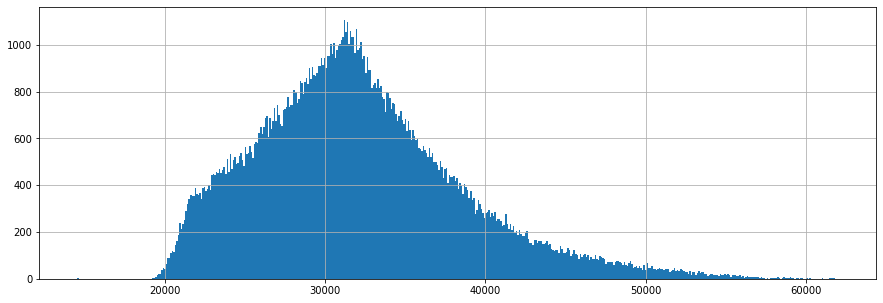

In [12]:
fig = plt.figure(figsize=(15,5))
df['PJME_MW'].hist(bins=500)

<AxesSubplot:title={'center':'Outliers'}, xlabel='Datetime'>

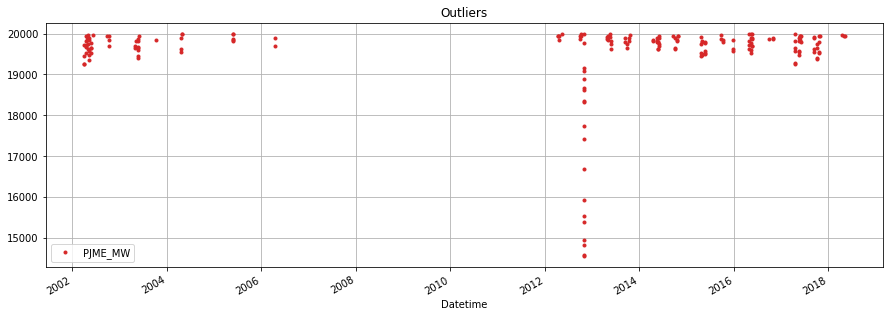

In [13]:
df[df['PJME_MW'] < 20000].plot(grid=True,
                               style='.',
                               figsize=(15, 5),
                               color=color_pal[3],
                               title='Outliers')

Based on above graph, we could interpret that there are outliers within the 2012-2014 grid, which are far below the lowest value of power consumed as displayed under the histogram (i.e. 20,000 MWs)

In [14]:
# here, we are excluding the outliers
# considering only those records for which power consumption is greater than 19000 MW

df = df[df['PJME_MW'] > 19000].copy()
print(df)

                     PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0
...                      ...
2018-01-01 20:00:00  44284.0
2018-01-01 21:00:00  43751.0
2018-01-01 22:00:00  42402.0
2018-01-01 23:00:00  40164.0
2018-01-02 00:00:00  38608.0

[145351 rows x 1 columns]


                     PJME_MW
Datetime                    
2008-03-07 01:00:00  28090.0
2008-03-07 02:00:00  27434.0
2008-03-07 03:00:00  27301.0
2008-03-07 04:00:00  27401.0
2008-03-07 05:00:00  28191.0
...                      ...
2008-03-01 20:00:00  35553.0
2008-03-01 21:00:00  35101.0
2008-03-01 22:00:00  34185.0
2008-03-01 23:00:00  32762.0
2008-03-02 00:00:00  31087.0

[167 rows x 1 columns]


<AxesSubplot:title={'center':'Weekly Data'}, xlabel='Datetime'>

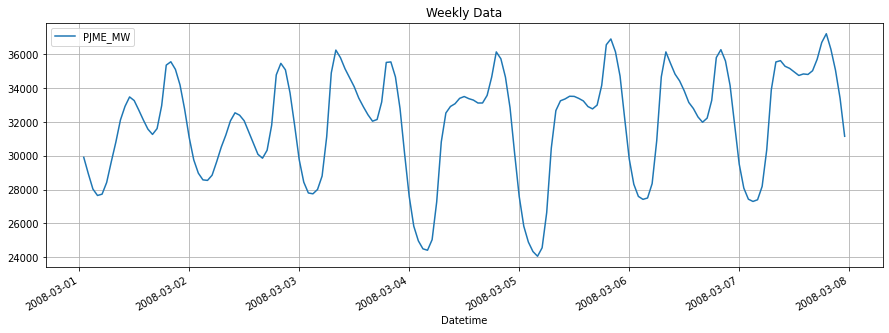

In [15]:
# analysing the weekly power consumption for some random date (say, from Mar 1 to Mar 7 in 2008)

rand_df = df.loc[(df .index > '2008-03-01') & (df.index < '2008-03-08')]
print(rand_df)
rand_df.plot(figsize=(15, 5), title='Weekly Data', grid=True)

In [16]:
def create_features(df):
    # Create time series features based on time series index
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

feat_df = create_features(df)

In [17]:
# mapping the days of a week with their respective codes as per the pandas library

feat_df['day_of_week'] = feat_df['dayofweek'].map({0: 'Monday',
                                                   1: 'Tuesday',
                                                   2: 'Wednesday',
                                                   3: 'Thursday',
                                                   4: 'Friday',
                                                   5: 'Saturday',
                                                   6: 'Sunday'})

In [18]:
feat_df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,day_of_week
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1,Tuesday
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1,Tuesday
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1,Tuesday
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1,Tuesday
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1,Monday
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1,Monday
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1,Monday


<AxesSubplot:title={'center':'Weekly Data'}, xlabel='day_of_week'>

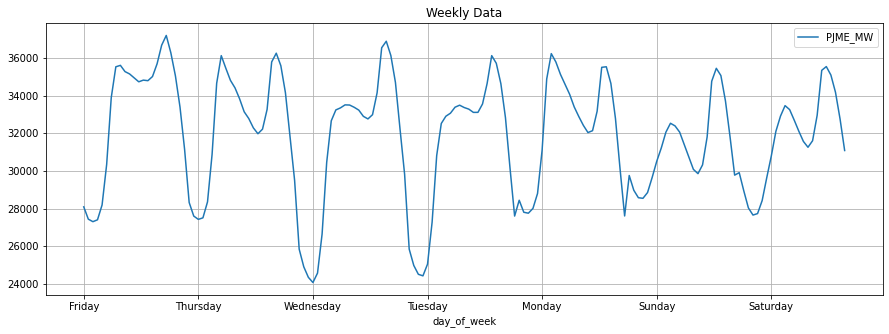

In [19]:
# visualizing the power consumption trend based on days of a week
# this helps us visualize in a more flexible way comparing the power consumed on weekdays vs. weekends

rand_df2 = feat_df.loc[(feat_df.index > '2008-03-01') & (feat_df.index < '2008-03-08')]
rand_df2[['PJME_MW', 'day_of_week']].plot(figsize=(15, 5), title='Weekly Data', grid=True, x='day_of_week')

### VISUALIZING FEATURES vs. TARGET RELATIONSHIP

<AxesSubplot:title={'center':'MW by Hour'}, xlabel='hour', ylabel='PJME_MW'>

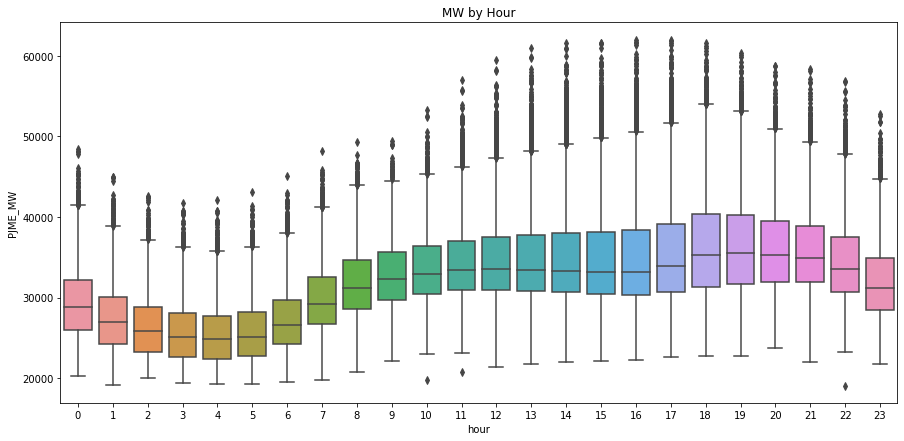

In [20]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_title('MW by Hour')
sns.boxplot(x='hour',
            y='PJME_MW',
            data=feat_df)

**Power Consumption per hour:**
- as per above graph, it could be visualized that the power consumption is comparatively lower during the inital hours of a day, and as we proceed closer towards the evening (i.e. the other half of the day), the power consumption value gets higher

<AxesSubplot:title={'center':'MW by Month'}, xlabel='month', ylabel='PJME_MW'>

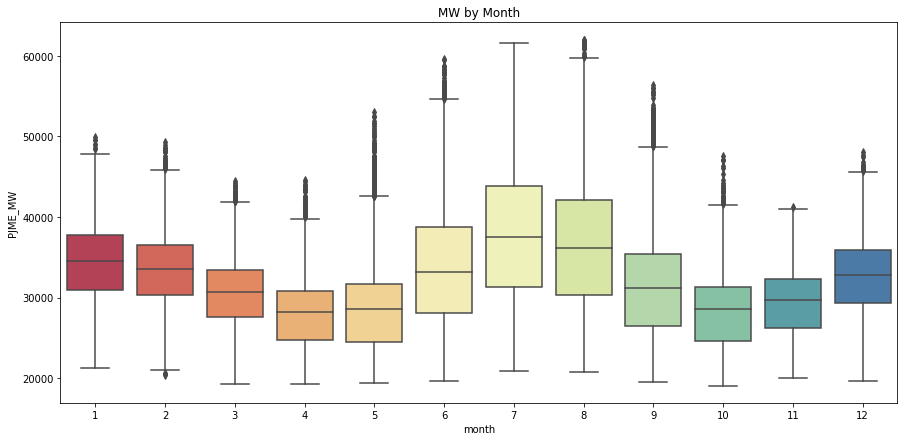

In [21]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_title('MW by Month')
sns.boxplot(x='month',
            y='PJME_MW', palette='Spectral',
            data=feat_df)

**Power Consumption per month:**
- as per above graph, it could be visualized that the power usage peaks up during the inital months of a year (during winter), and then there's a dip in power usage, sometime around spring nand during the fall period. However again, with the onset of summer, the power usage spikes up due to the usage of air conditioners, and other such gadgets.

### TRAIN/TEST SPLIT

In [22]:
# for training-test split, we would be using the ratio as 75:25
# since, the total numbers of rows equals 1,45,351 -- 75% of the total data would account for nearly 1,09,000 rows
# so, as per below calculation, we would be considering the training dataset for all records dating prior to July 1, 2014
# while the test dataset would comprise of the records for rest of the dates, starting July 1, 2014 till the end of 2018

In [23]:
df[df.index < '2014-07-01']

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2014-01-01 20:00:00,36193.0
2014-01-01 21:00:00,35601.0
2014-01-01 22:00:00,34242.0


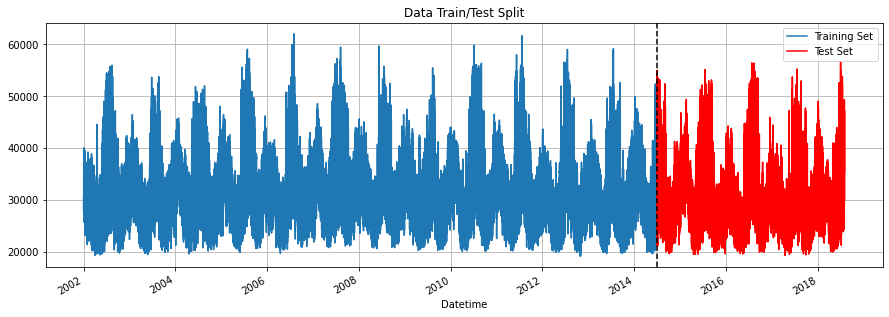

In [24]:
# here, we are segmenting our taining and test data over the 'df' dataframe
# as we do not require the additional features such as day of week, month, hour etc. here
# which are included under the 'feat_df' dataframe

train_data = df[feat_df.index < '2014-07-01']
test_data = df[feat_df.index >= '2014-07-01']

fig, ax = plt.subplots(figsize=(15, 5))
train_data.plot(ax=ax, label='Training Set', title='Data Train/Test Split', grid=True)
test_data.plot(ax=ax, label='Test Set', color='red', grid=True)
ax.axvline('2014-07-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### CREATING THE MODEL

In [25]:
# since, it's a regression task, we would be creating a regression model based on XGBoost's Regressor

In [26]:
train_data = create_features(train_data)
test_data = create_features(test_data)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

In [27]:
reg = xgb.XGBRegressor(booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

# verbose=100 indicates the display or printing of training & validation scores after every 100th tree that is built

[14:46:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32651.94762	validation_1-rmse:31631.98027
[100]	validation_0-rmse:12598.12307	validation_1-rmse:11653.31166
[200]	validation_0-rmse:5830.66759	validation_1-rmse:5246.86908
[300]	validation_0-rmse:3906.75228	validation_1-rmse:3902.34687
[400]	validation_0-rmse:3435.65315	validation_1-rmse:3773.18663
[500]	validation_0-rmse:3280.62132	validation_1-rmse:3750.20519
[600]	validation_0-rmse:3204.80600	validation_1-rmse:3737.91446
[700]	validation_0-rmse:3148.20001	validation_1-rmse:3710.73578
[800]	validation_0-rmse:3108.01752	validation_1-rmse:3693.49006
[900]	validation_0-rmse:3077.49327	validation_1-rmse:3691.47860


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

### FEATURE IMPORTANCE

In [28]:
reg.feature_importances_

array([0.09510402, 0.23888181, 0.13472533, 0.0763962 , 0.44002306,
       0.01486948], dtype=float32)

In [29]:
feat_corr = pd.DataFrame(data=reg.feature_importances_,
                        index=reg.feature_names_in_,
                        columns=['coefficient'])

In [30]:
feat_corr.sort_values(by='coefficient',
                      ascending=False)

,coefficient
month,0.440023
hour,0.238882
dayofweek,0.134725
dayofyear,0.095104
quarter,0.076396
year,0.014869


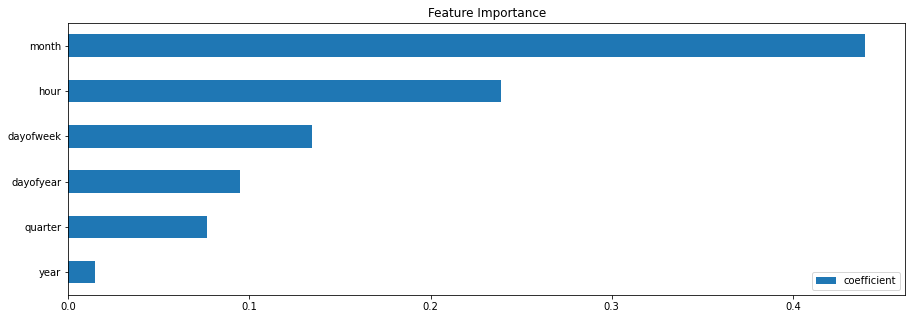

In [31]:
feat_corr.sort_values(by='coefficient').plot(kind='barh', title='Feature Importance', figsize=(15, 5))
plt.show()

In [32]:
test_data['Predictions'] = reg.predict(X_test)

In [33]:
df = df.merge(test_data['Predictions'], how='left', left_index=True, right_index=True)

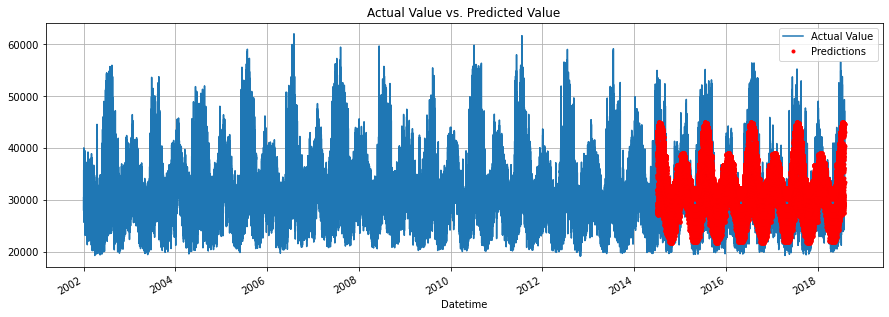

In [34]:
ax = df['PJME_MW'].plot(figsize=(15, 5))
df['Predictions'].plot(ax=ax, style='.', grid=True, color='red')
plt.legend(['Actual Value', 'Predictions'])
ax.set_title('Actual Value vs. Predicted Value')
plt.show()

In [35]:
rand_df3 = df.loc[(df.index > '2018-04-01') & (df.index < '2018-04-08')]

In [36]:
rand_df3

,PJME_MW,Predictions
Datetime,,
2018-04-01 01:00:00,23687.0,23713.853516
2018-04-01 02:00:00,22858.0,22531.542969
2018-04-01 03:00:00,22333.0,21963.382812
2018-04-01 04:00:00,22058.0,21963.382812
2018-04-01 05:00:00,22093.0,21963.382812
...,...,...
2018-04-07 19:00:00,28608.0,28583.054688
2018-04-07 20:00:00,29663.0,28583.054688
2018-04-07 21:00:00,30278.0,28566.896484


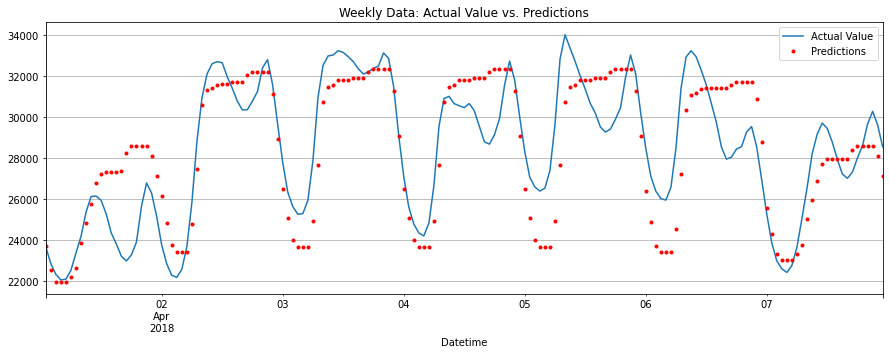

In [37]:
ax = rand_df3['PJME_MW'].plot(figsize=(15, 5), title='Weekly Data: Actual Value vs. Predictions')
rand_df3['Predictions'].plot(style='.', color='red', grid=True)
plt.legend(['Actual Value','Predictions'])
plt.show()

Visualizing above graph, we could interpret that the model could perform even better by tuning of hyperparameters, however, our model does follow the actual trend of dips and spikes compared with the actual value

### EVALUATING ERROR METRIC USING RMSE

In [38]:
score = np.sqrt(mean_squared_error(test_data['PJME_MW'], test_data['Predictions']))

In [39]:
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3689.49


In [40]:
# calculating the difference (margin) between the actual and predicted value
test_data['error_margin'] = np.abs(test_data['PJME_MW'] - test_data['Predictions'])

In [41]:
test_data[['PJME_MW', 'Predictions', 'error_margin']]

,PJME_MW,Predictions,error_margin
Datetime,,,
2014-12-31 01:00:00,30795.0,28237.064453,2557.935547
2014-12-31 02:00:00,29995.0,27272.425781,2722.574219
2014-12-31 03:00:00,29688.0,26942.257812,2745.742188
2014-12-31 04:00:00,29767.0,26942.257812,2824.742188
2014-12-31 05:00:00,30426.0,26942.257812,3483.742188
...,...,...,...
2018-01-01 20:00:00,44284.0,36749.984375,7534.015625
2018-01-01 21:00:00,43751.0,36733.824219,7017.175781
2018-01-01 22:00:00,42402.0,35271.667969,7130.332031


In [42]:
# Best predicted days

test_data[['PJME_MW', 'Predictions', 'error_margin']].sort_values('error_margin', ascending = True).head()

,PJME_MW,Predictions,error_margin
Datetime,,,
2016-06-02 04:00:00,24502.0,24502.068359,0.068359
2015-02-12 00:00:00,32043.0,32043.144531,0.144531
2017-11-24 08:00:00,30723.0,30722.832031,0.167969
2016-08-01 07:00:00,32950.0,32949.726562,0.273438
2018-05-23 13:00:00,32733.0,32732.625000,0.375000


In [43]:
# Worst predicted days

test_data[['PJME_MW', 'Predictions', 'error_margin']].sort_values('error_margin', ascending = False).head()

,PJME_MW,Predictions,error_margin
Datetime,,,
2016-09-10 16:00:00,50253.0,32262.642578,17990.357422
2016-09-10 15:00:00,49988.0,32243.892578,17744.107422
2016-09-10 17:00:00,50249.0,32801.179688,17447.820312
2016-09-10 14:00:00,49136.0,32243.892578,16892.107422
2016-09-10 18:00:00,49494.0,32946.183594,16547.816406


Based on above data, we could conclude that our model performed fairly poor while predicting the power consumption specific to Sep 10, 2016, wherein there's an error margin ranging around ~17000 Megawatts between the actual power comsumed and the predicted value

## APPLYING THE CONCEPTS & STEPS FOR FUTURE PREDICTION

In [44]:
df = df.drop(columns=['Predictions'])

### TIME SERIES CROSS VALIDATION

In [45]:
from sklearn.model_selection import TimeSeriesSplit

In [46]:
# Provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets
# In each split, test indices must be higher than before, and thus shuffling in cross validator is inappropriate

tss = TimeSeriesSplit(n_splits=5, max_train_size=None, test_size=24*365*1, gap=24)
df = df.sort_index()
# if we do not sort our dataframe based on index, the cross validation algorithm won't work

# gap: Number of samples to exclude from the end of each training set before the test set begins
# gap=24 means we are setting up a gap of duration 24 hours in between when a training set end and a test set begins

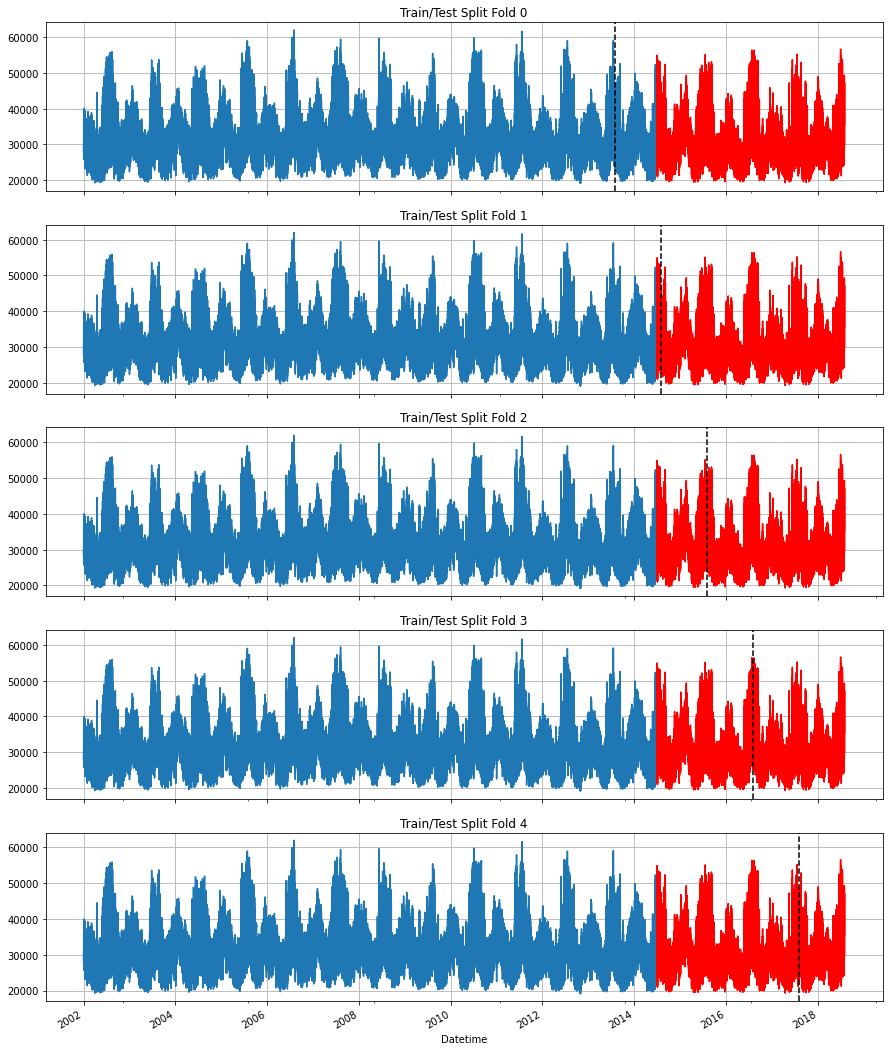

In [47]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
# 'sharex' attribute allows us to have a common x-axis shared for all the subplots

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train_data['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Train/Test Split Fold {fold}',
                              grid=True)
    test_data['PJME_MW'].plot(ax=axs[fold],
                              label='Test Set',
                              grid=True,
                             color='red')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

### FORECASTING HORIZON
The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

### LAG FEATURES
- What was the target (X) days in the past?
> So basically, we are asking the model to look back in past (say, X days back) and use the target value for that many days in the past as a new feature that we feed into the model

In [48]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    # mapping each of the power consumed data with the corresponding datetime value
    # we will use this dictionary object to map the lag features on our dataframe
    
    # Timedelta(): represents a duration, the difference between two dates or times
    # we are subtracting 364 days instead of 365 days as 364 is exactly divisible by 7
    # and this will return us the exact same day of the week for last year
    # so we don't have to worry about mapping the days of the week for the past year(s)
    
    df['lag_1'] = (df.index - pd.Timedelta('364 days')).map(target_map) # ----------- one year lag variable
    df['lag_2'] = (df.index - pd.Timedelta('728 days')).map(target_map) # ----------- two year lag variable
    df['lag_3'] = (df.index - pd.Timedelta('1092 days')).map(target_map) # ----------- three year lag variable
    return df

In [49]:
df = add_lags(df)

In [50]:
df.tail()
# the lag features that have been added to our dataframe below will be helpful while training our model

,PJME_MW,lag_1,lag_2,lag_3
Datetime,,,,
2018-08-02 20:00:00,44057.0,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,33539.0,32094.0,31695.0


### TRAIN USING CROSS VALIDATION

In [51]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, test_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag_1', 'lag_2', 'lag_3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                          n_estimators=1000, early_stopping_rounds=50,
                          objective='reg:linear', max_depth=3,
                          learning_rate=0.01)
    reg.fit(X_train, y_train, verbose= 100,
            eval_set = [(X_train, y_train), (X_test, y_test)])
    
    y_pred = reg.predict(X_test) # predicting the values for test data records
    preds.append(y_pred) # adding prediction on each test value to our 'preds'list
    score = np.sqrt(mean_squared_error(y_test, y_pred)) #evaluating the error metric and storing it in 'score' variable
    scores.append(score) # adding the score value for each fold to our 'scores' list
    # we will analyze the score values across all the 5 folds to evaluate the performance of our model

[14:46:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.17016	validation_1-rmse:31957.46195
[100]	validation_0-rmse:12532.22164	validation_1-rmse:11908.76676
[200]	validation_0-rmse:5745.83030	validation_1-rmse:5354.79180
[300]	validation_0-rmse:3868.68548	validation_1-rmse:3891.81473
[400]	validation_0-rmse:3431.16882	validation_1-rmse:3753.71787
[451]	validation_0-rmse:3356.27089	validation_1-rmse:3759.11047
[14:47:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32671.62712	validation_1-rmse:32140.95141
[100]	validation_0-rmse:12513.08470	validation_1-rmse:12226.13724
[200]	validation_0-rmse:5755.22292	validation_1-rmse:5657.75940
[300]	validation_0-rmse:3903.55867	validation_1-rmse:3928.60801
[4

In [52]:
# analyzing the above report:
# fold 1: model starts overfitting post 452nd iteration
# fold 2: model doesn't overfit
# fold 3: model starts overfitting post 414th iteration
# fold 4: model starts overfitting post 796th iteration
# fold 5: model starts overfitting post 446th iteration

In [53]:
print(f'Mean score across folds: {np.mean(scores):0.3f}')
print(f'Fold scores:{scores}')

Mean score across folds: 3748.716
Fold scores:[3752.451699385187, 3430.8296507420064, 3473.5910055942218, 4088.366446083896, 3998.3428588385277]


In [54]:
scores_df = pd.DataFrame(scores, columns=['Score'])

In [55]:
scores_df

,Score
0,3752.451699
1,3430.829651
2,3473.591006
3,4088.366446
4,3998.342859


### PREDICTING THE FUTURE:
- Re-training on entire dataset
- To predict the future we need an empty dataframe for future date ranges
- Run those dates through our feature creation code + lag creation function

In [56]:
# Retrain on entire dataset
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag_1','lag_2','lag_3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

# setting up 500 estimations based on cross validation report as the model starts overfitting post 500th iteration (on an average)
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=50)

[14:50:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.38974
[50]	validation_0-rmse:19874.31789
[100]	validation_0-rmse:12426.26466
[150]	validation_0-rmse:8115.77519
[200]	validation_0-rmse:5751.60495
[250]	validation_0-rmse:4548.37816
[300]	validation_0-rmse:3969.74285
[350]	validation_0-rmse:3698.49726
[400]	validation_0-rmse:3569.00964
[450]	validation_0-rmse:3497.14857
[499]	validation_0-rmse:3454.79265


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [57]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [58]:
# so for creating a future dataframe consisting of the predicted future values using data_range() method
# we would be considering 2018-08-03 as our start date
# and let's assume we want to predict for next 1 year, so the end date should be 2019-08-03

#### CREATING A DATAFRAME CONSISTING OF PREDICTED FUTURE VALUES

In [59]:
future = pd.date_range('2018-08-03','2019-08-03', freq='1h')
future_df = pd.DataFrame(index=future)

# adding a new column to the df so as to easily identify which is a future value and which one's not
future_df['isFuture'] = True
df['isFuture'] = False

f_pred_df = pd.concat([df, future_df]) # merging both the raw and future dataframes
f_pred_df = create_features(f_pred_df)
f_pred_df = add_lags(f_pred_df)

In [60]:
f_pred_df

,PJME_MW,lag_1,lag_2,lag_3,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,isFuture
2002-01-01 01:00:00,30393.0,NaN,NaN,NaN,1,1,1,1,2002,1,1,1,False
2002-01-01 02:00:00,29265.0,NaN,NaN,NaN,2,1,1,1,2002,1,1,1,False
2002-01-01 03:00:00,28357.0,NaN,NaN,NaN,3,1,1,1,2002,1,1,1,False
2002-01-01 04:00:00,27899.0,NaN,NaN,NaN,4,1,1,1,2002,1,1,1,False
2002-01-01 05:00:00,28057.0,NaN,NaN,NaN,5,1,1,1,2002,1,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-02 20:00:00,NaN,NaN,43606.0,40513.0,20,4,3,8,2019,214,2,31,True
2019-08-02 21:00:00,NaN,NaN,41863.0,39840.0,21,4,3,8,2019,214,2,31,True
2019-08-02 22:00:00,NaN,NaN,40005.0,38664.0,22,4,3,8,2019,214,2,31,True
2019-08-02 23:00:00,NaN,NaN,37174.0,36125.0,23,4,3,8,2019,214,2,31,True


In [61]:
# now we would be segregating the entire future dataframe from this merged dataframe
# so the newer dataframe that we will receive will have the future dates alongwith the corresponding lag values & features
# we would be labelling this new dataframe as fwf (future with features)

In [62]:
fwf = f_pred_df[f_pred_df['isFuture'] == True]

In [63]:
fwf

,PJME_MW,lag_1,lag_2,lag_3,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,isFuture
2018-08-03 00:00:00,NaN,33539.0,32094.0,31695.0,0,4,3,8,2018,215,3,31,True
2018-08-03 01:00:00,NaN,30781.0,29503.0,29128.0,1,4,3,8,2018,215,3,31,True
2018-08-03 02:00:00,NaN,29015.0,27712.0,27373.0,2,4,3,8,2018,215,3,31,True
2018-08-03 03:00:00,NaN,27884.0,26535.0,26233.0,3,4,3,8,2018,215,3,31,True
2018-08-03 04:00:00,NaN,27223.0,25870.0,25643.0,4,4,3,8,2018,215,3,31,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-02 20:00:00,NaN,NaN,43606.0,40513.0,20,4,3,8,2019,214,2,31,True
2019-08-02 21:00:00,NaN,NaN,41863.0,39840.0,21,4,3,8,2019,214,2,31,True
2019-08-02 22:00:00,NaN,NaN,40005.0,38664.0,22,4,3,8,2019,214,2,31,True
2019-08-02 23:00:00,NaN,NaN,37174.0,36125.0,23,4,3,8,2019,214,2,31,True


#### PREDICT THE POWER CONSUMPTION VALUE FOR THESE FUTURE DATES

In [64]:
# creating a new 'Predictions' column for storing the predicted values under the dataframe
fwf['Predictions'] = reg.predict(fwf[FEATURES])

C:\Users\SU20123172\AppData\Local\Temp\ipykernel_44028\2041794988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fwf['Predictions'] = reg.predict(fwf[FEATURES])


In [65]:
fwf

,PJME_MW,lag_1,lag_2,lag_3,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,isFuture,Predictions
2018-08-03 00:00:00,NaN,33539.0,32094.0,31695.0,0,4,3,8,2018,215,3,31,True,30776.292969
2018-08-03 01:00:00,NaN,30781.0,29503.0,29128.0,1,4,3,8,2018,215,3,31,True,28563.724609
2018-08-03 02:00:00,NaN,29015.0,27712.0,27373.0,2,4,3,8,2018,215,3,31,True,27977.009766
2018-08-03 03:00:00,NaN,27884.0,26535.0,26233.0,3,4,3,8,2018,215,3,31,True,27379.611328
2018-08-03 04:00:00,NaN,27223.0,25870.0,25643.0,4,4,3,8,2018,215,3,31,True,27066.751953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-02 20:00:00,NaN,NaN,43606.0,40513.0,20,4,3,8,2019,214,2,31,True,39696.535156
2019-08-02 21:00:00,NaN,NaN,41863.0,39840.0,21,4,3,8,2019,214,2,31,True,39539.062500
2019-08-02 22:00:00,NaN,NaN,40005.0,38664.0,22,4,3,8,2019,214,2,31,True,38707.984375
2019-08-02 23:00:00,NaN,NaN,37174.0,36125.0,23,4,3,8,2019,214,2,31,True,37672.667969


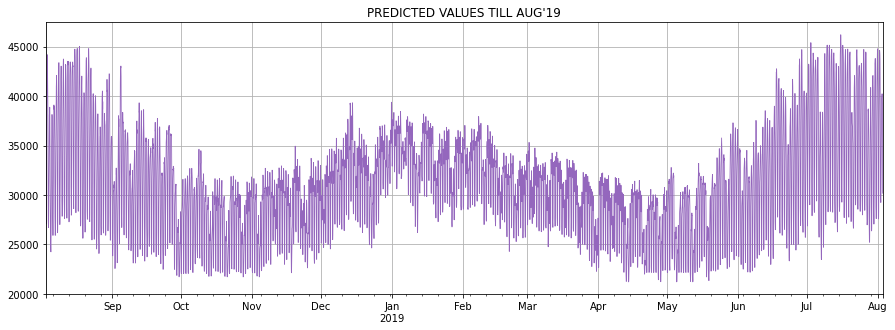

In [66]:
fwf['Predictions'].plot(figsize=(15, 5),
                        color=color_pal[4],
                        ms=1, lw=0.8, grid=True, 
                        title='PREDICTED VALUES TILL AUG\'19')
plt.show()

### SAVING THE MODEL
> We have a regressor model that was trained, now we don't want to train the model every single time. So here, we could save in our model and later load it up for newer task as per the requirement.

In [67]:
reg.save_model('ec_XGB_model.json')

**SINCE WE HAVE OUR MODEL SAVED WE CAN REUSE THE SAME MODEL OVER SOME OTHER DATA**

**IN THAT CASE WE NEED TO FIRST LOAD OUR MODEL & THEN PREDICT THE REQUIRED VALUES USING THE NEW REGRESSOR OBJECT**

- reg_new = xgb.XGBRegressor()
- reg_new.load_model('ec_XGB_model.json')
- sample_data['predictions'] = reg_new.predict(sample_data[FEATURES])